## Autograph

* Using AutoGraph is extremely easy: the only thing that you need to do is to annotate your Python code with the special decorator tf.function as in the following code example.

*  there is no need to annotate linear_layer.

In [1]:
import tensorflow as tf

def linear_layer(x):
    return 3 * x + 2

@tf.function
def simple_nn(x):
    return tf.nn.relu(linear_layer(x))

def simple_function(x):
    return 3*x

In [2]:
simple_nn

In [3]:
simple_function

<function __main__.simple_function(x)>

In [4]:
# internal look at the auto-generated code
print(tf.autograph.to_code(simple_nn.python_function, experimental_optional_features=None))

def tf__simple_nn(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('simple_nn', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
    do_return = True
    retval_ = fscope.mark_return_value(ag__.converted_call(tf.nn.relu, (ag__.converted_call(linear_layer, (x,), None, fscope),), None, fscope))
  do_return,
  return ag__.retval(retval_)



* Let's see an example of the difference in speed between code annotated with the tf.function() decorator and the same code with no annotation. Here we use a layer LSTMCell() which will be discussed in Chapter 8, Recurrent Neural Networks, but for now consider it as a black box doing some form of learning:

In [5]:
import tensorflow as tf
import timeit
cell = tf.keras.layers.LSTMCell(100)

@tf.function
def fn(input, state):
    return cell(input, state)

input = tf.zeros([100, 100])
state = [tf.zeros([100, 100])] * 2

# warmup
cell(input, state)
fn(input, state)

graph_time = timeit.timeit(lambda: cell(input, state), number=100)
auto_graph_time = timeit.timeit(lambda: fn(input, state), number=100)

print('graph_time:', graph_time)
print('auto_graph_time:', auto_graph_time)

graph_time: 0.18826654699999956
auto_graph_time: 0.08413733799999967


# Define Model in 3 ways

### 1. Sequential API

In [6]:
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10   # number of outputs = number of digits
N_HIDDEN = 128
RESHAPED = 784

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10,
          input_shape=(RESHAPED,),
          name='dense_layer', activation='relu'))
model.add(tf.keras.layers.Dense(N_HIDDEN,
          name='dense_layer_2', activation='relu'))
model.add(tf.keras.layers.Dense(NB_CLASSES,
          name='dense_layer_3', activation='softmax'))

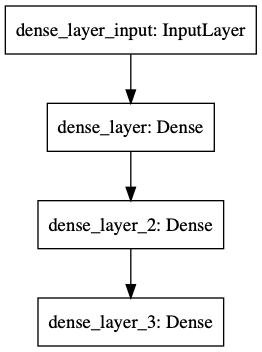

In [8]:
tf.keras.utils.plot_model(model, to_file="model.png")

## Functional API

* The Functional API is useful when you want to build a model with more complex (non-linear) topologies, including multiple inputs, multiple outputs, residual connections with non-sequential flows, and shared and reusable layers. Each layer is callable (with a tensor in input), and each layer returns a tensor as an output. 

In [9]:
import tensorflow as tf
def build_model():
    # variable-length sequence of integers
    text_input_a = tf.keras.Input(shape=(None,), dtype='int32')
    # variable-length sequence of integers
    text_input_b = tf.keras.Input(shape=(None,), dtype='int32')
    # Embedding for 1000 unique words mapped to 128-dimensional vectors
    shared_embedding = tf.keras.layers.Embedding(1000, 128)
    # We reuse the same layer to encode both inputs
    encoded_input_a = shared_embedding(text_input_a)
    encoded_input_b = shared_embedding(text_input_b)
    # two logistic predictions at the end
    prediction_a = tf.keras.layers.Dense(1, activation='sigmoid',\
name='prediction_a')(encoded_input_a)
    prediction_b = tf.keras.layers.Dense(1, activation='sigmoid',\
 name='prediction_b')(encoded_input_b)
    # this model has 2 inputs, and 2 outputs
    # in the middle we have a shared model
    model = tf.keras.Model(inputs=[text_input_a, text_input_b], 
    outputs=[prediction_a, prediction_b])
    tf.keras.utils.plot_model(model, to_file="shared_model.png")
    return model
model = build_model()


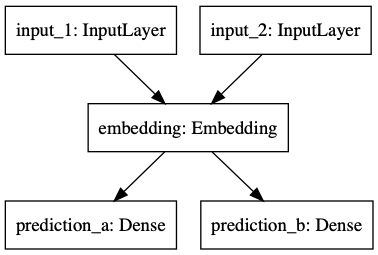

In [10]:
tf.keras.utils.plot_model(model, to_file="model.png")

## 3. Model subclassing

In [11]:
class MyLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                  shape=(input_shape[1], self.output_dim),
                                  initializer='uniform',
                                  trainable=True)
    def call(self, inputs):
        # Do the multiplication and return 
        return tf.matmul(inputs, self.kernel)


In [12]:
model = tf.keras.Sequential([
    MyLayer(20),
    tf.keras.layers.Activation('softmax')])

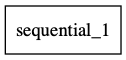

In [13]:
tf.keras.utils.plot_model(model, to_file="model.png")

## Callbacks

Callbacks are objects passed to a model to extend or modify behaviors during training. There are a few useful callbacks that are commonly used in tf.keras:


* tf.keras.callbacks.ModelCheckpoint: This feature is used to save checkpoints of your model at regular intervals and recover in case of problems.


* tf.keras.callbacks.LearningRateScheduler: This feature is used to dynamically change the learning rate during optimization.


* tf.keras.callbacks.EarlyStopping: This feature is used to interrupt training when validation performance has stopped improving after a while.


* tf.keras.callbacks.TensorBoard: This feature is used to monitor the model's behavior using TensorBoard.

## Model Save and load

* Save weights to a Tensorflow Checkpoint file

    model.save_weights('./weights/my_model')
    
    
* Save weights to a HDF5 file

    model.save_weights('my_model.h5', save_format='h5')


* Weights are easily loaded with Restore the model's state

    model.load_weights(file_path)    
    
    
In addition to weights, a model can be serialized in JSON with:

```Python
json_string = model.to_json()  # save 
model = tf.keras.models.model_from_json(json_string) # restore    
```
* If you want to save a model together with its weights and the optimization parameters, then you simply use:

```Python
model.save('my_model.h5') # save
model = tf.keras.models.load_model('my_model.h5') #restore
```

# Training from tf.data.datasets

#### Package : tensorflow-datasets

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [15]:
# see all registered datasets
builders  = tfds.list_builders()
print(builders)

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'arc', 'bair_robot_pushing_small', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'cos_e', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'esnli', 'eurosat', 'fashion_mnist', 'flic', 'flores', 'food101', 'gap', 'gigaword', 'glue', 'groove', 'higgs', 'horses_or_humans', 'i_naturalist2017', 'image_label_folder', 'imagenet2012', 'imagenet201

In [16]:
# load a dataset with its metadata

data,info = tfds.load("mnist",with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



### Create a datset from numpy array

In [17]:
import tensorflow as tf
import numpy as np

num_items = 100
num_list = np.arange(num_items)
print(num_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [18]:
# create the dataset from numpy array

num_list_dataset = tf.data.Dataset.from_tensor_slices(num_list)
num_list_dataset

<TensorSliceDataset shapes: (), types: tf.int64>

### Download a dataset, shuffle and batch the data

In [19]:
datasets, info = tfds.load("imdb_reviews",with_info= True , as_supervised=True)

Shuffling and writing examples to /Users/bat/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNK35AG/imdb_reviews-train.tfrecord


Shuffling and writing examples to /Users/bat/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNK35AG/imdb_reviews-test.tfrecord


Shuffling and writing examples to /Users/bat/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNK35AG/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /Users/bat/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [20]:
datasets

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>}

In [21]:
train_dataset = datasets['train']

In [22]:
train_dataset = train_dataset.batch(5).shuffle(50).take(2)

In [23]:
for data in train_dataset:
    print(data)
    break

(<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b"With a minimal budget, a running time of eight minutes and a great amount of imagination, Nacho Vigalondo has achieved one of the most moving shorts I've ever seen. The subtlety of the screenplay is really remarkable, since it doesn't give the ending away until the very last moment.<br /><br />Don't let anybody tell you what the short is about, since you'll be able to enjoy it a lot more. Nacho Vigalondo is the discovery of the year for his one-man show: directing, writing and acting in this formidable short is the most remarkable effort I've seen in years. Also pay attention to the performance of Marta Belenguer, her reaction shots are incredible.<br /><br />Overall rating: 8/10",
       b"I was not entirely impressed by this film. It was originally named Sin Eater and should have stayed that way considering that is all that was talked about for the last half of the film. I'm not even sure what the first 20 minutes of the film had

### Important function of tfds

1. Creation:
    * Via from_tensor_slices(), which accepts individual (or multiple) NumPy (or tensors) and supports batches
    * Via from_tensors(), which is similar to the above but it does not support batches
    * Via from_generator(), which takes input from a generator function


2. Transformation:
    * Via batch(), which sequentially divides the dataset by the specified size
    * Via repeat(), which duplicates the data
    * Via shuffle(), which randomly shuffles the data
    * Via map(), which applies a function to the data
    * Via filter(), which applies a function to filter the data


3. Iterators:
    * Via next_batch = iterator.get_next()

# Estimators

In addition to the direct graph computation and to the tf.keras higher-level APIs, TensorFlow 1.x and 2.x have an additional set of higher-level APIs called **Estimators**.

Another way to build or to use prebuilt bricks. A longer answer is that they are highly efficient learning models for large-scale production-ready environments, which can be trained on single machines or on distributed multi-servers, and they can run on CPUs, GPUs, or TPUs without recoding your model. These models include Linear Classifiers, Deep Learning Classifiers, Gradient Boosted Trees, and many more, 


* Build a DNN with 2 hidden layers. And 10 nodes in each hidden layers and 3 classes

```Python

selected_columns = []
classifier = tf.estimator.DNNClassifier(feature_columns=selected_columns,hidden_units = [10,10],n_classes=3)



* Fetch the data

(train_X,train_y), (test_X, test_y) = load_data()
my_columns = []

for key in train_X.keys():
    my_columns.append(tf.feature_column.numeric_column(key=key))
    
```


* Efficiency Estimators should be trained using tf.Datasets as input. Here is an example where MNIST is loaded, scaled, shuffled, and batched:

In [24]:
# Example

import tensorflow as tf
import tensorflow_datasets as tfds

BUFFER_SIZE = 10000
BATCH_SIZE = 64


def input_fn(mode):
    dataset, info = tfds.load(name = 'mnist',with_info = True,as_supervised = True)
    mnist_dataset = (dataset['train'] if mode == tf.estimator.ModeKeys.TRAIN else dataset['test'])
    
    def scale(image,label):
        image = tf.cast(image,tf.float32)
        image /= 255.
        return image, label
    
    return mnist_dataset.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test = input_fn('test')
train = input_fn(tf.estimator.ModeKeys.TRAIN)

print(test)
print(train)



<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


```Python
tf.estimator.train_and_evaluate(classifier,train_spec=tf.estimator.TrainSpec(input_fn=input_fn),
                               eval_spec=tf.estimator.EvalSpec(input_fn=input_fn))

```

* TensorFlow contains Estimators for both regression and classification.


* Estimators fully support distributed training while tf.keras has limited support. 


* Given this, a possible workaround is to transform tf.keras models into Estimators with tf.keras.estimator.model_to_estimator() and then use the full distributed training support.

# Custom training

TensorFlow can compute gradients on our behalf (automatic differentiation) and this makes it extremely easy to develop machine learning models. 

There are multiple ways of computing gradients.

###  1. tf.GradientTape() :
    This class record operation for automatic differentiation. 
    
    **Percistent = True ** (Multiple calls can be made to the gradient() method on this object)
    
    

In [25]:
import tensorflow as tf
x = tf.constant(4.0)

with tf.GradientTape(persistent= True) as g:
    g.watch(x)
    y = x * x
    z = y * y

dz_dx = g.gradient(z,x)

# 4x^3
print(dz_dx.numpy())

# 2x
dy_dx = g.gradient(y,x)
print(dy_dx.numpy())

del g

256.0
8.0


###  2. tf.gradient_function :

    This return a function that computes the derivatives of its input function paramets with respect to its arguments.

### 3. tf.value_and_gradients_function(): 

This returns the value from the input function in addition to the list of derivatives of the input function with respect to its arguments.


### 4. tf.implicit_gradients(): 

This computes the gradients of the outputs of the input function with regards to all trainable variables these outputs depend on.



``` Python
@tf.function
def train_step(inputs,labels):
    with tf.GradientTape as tape:
        predictions = model(inputs, training = True)
        
        regularized_loss = r_l
        pred_loss = p_l
        
        total_losss = regularized_loss + pred_loss
        
    gradients = tape.gradients(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    
for epoch in range(epochs) :
    for inputs,labels in train_data:
        train_step(inputs,labels)
    print('Finished epoch : ', epoch)
    
```    

# Working with multiple GPUs

If we want to have synchronous distributed training on multiple GPUs on one machine, there are two things that we need to do: 
1. We need to load the data in a way that will be distributed into the GPUs.


2. We need to distribute some computations into the GPUs too:

In [26]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras

n_examples = 1024 * 1024
n_features = 10
batch_size = 256

x = np.random.random((n_examples,n_features))
y = np.random.randint(2,size = (n_examples,1))
x = tf.cast(x,tf.float32)

print(x.shape[0])
print(y.shape)
dataset = tf.data.Dataset.from_tensor_slices((x,y))
dataset = dataset.shuffle(buffer_size = n_examples).batch(batch_size)

1048576
(1048576, 1)


* In order to distribute some computations to GPUs, we instantiate a **distribution = tf.distribute.MirroredStrategy()** object, which supports synchronous distributed training on multiple GPUs on one machine. Then, we move the creation and compilation of the Keras model inside the strategy.scope(). 

* each variable in the model is mirrored across all the replicas. 

In [27]:
# this is the distribution strategy
distribution = tf.distribute.MirroredStrategy()

# this piece of code is distributed to multiple GPUs
with distribution.scope():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(N_FEATURES,)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.SGD(0.2)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()
# Optimize in the usual way but in reality you are using GPUs.
model.fit(dataset, epochs=5, steps_per_epoch=10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


NameError: name 'N_FEATURES' is not defined

Note that each batch of the given input is divided equally among the multiple GPUs. 

For instance, if using MirroredStrategy() with two GPUs, each batch of size 256 will be divided among the two GPUs, with each of them receiving 128 input examples for each step. 

In addition, note that each GPU will optimize on the received batches and the TensorFlow backend will combine all these independent optimizations on our behalf. 

Example Code at : (https://colab.research.google.com/drive/1mf-PK0a20CkObnT0hCl9VPEje1szhHat#scrollTo=wYar3A0vBVt)

#  MultiWorkerMirroredStrategy

This strategy implements synchronous distributed training across multiple workers, each one with potentially multiple GPUs. 

As of September 2019 the strategy works only with Estimators and it has experimental support for tf.keras. 

This strategy should be used if you are aiming at scaling beyond a single machine with high performance. 

Data must be loaded with tf.Dataset and shared across workers so that each worker can read a unique subset.

# Useful namespace info :

* tf.keras.layers: Contains all symbols that were previously under tf.layers

* tf.keras.losses: Contains all symbols that were previously under tf.losses

* tf.keras.metrics: Contains all symbols that were previously under tf.metrics

* tf.debugging: A new namespace for debugging

* tf.dtypes: A new namespace for data types

* tf.io: A new namespace for I/O

* tf.quantization: A new namespace for quantization

![image](tf.png)